# Notebook 024: Logistic Classifier Models using final predictor set

This notebook contains a baseline crime-type classifier model using an initial set of property-related predictors.

The response variable is:

       'crime-type'

Features used in this initial baseline model include:

       'commercial-mix-ratio', 'industrial-mix-ratio', 'owner-occupied-ratio',
       'residential-median-value', 'residential-gini-coef',
       'industrial-mix-ratio-3yr-cagr', 'commercial-mix-ratio-3yr-cagr',
       'owner-occupied-ratio-3yr-cagr', 'residential-median-value-3yr-cagr',
       'residential-gini-coef-3yr-cagr', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday', 'Saturday', 'Sunday', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'night'

The baseline models tested are Multi-class Logistic Regression Models with and without regularization.

In [1]:
import urllib
import os
import operator
import pathlib
import requests
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import statsmodels.api as sm

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
DATA_ROOT = '../data/'
FIGURES_ROOT = '../figures/model-logistic'
WRITEDIR_ROOT = '../models/logistic'

READDIR_ROOT = os.path.join(DATA_ROOT, 'processed')
SHAPEDIR_ROOT = os.path.join(DATA_ROOT, 'raw')

readfile_model_X = os.path.join(READDIR_ROOT, 'X_train.csv')
readfile_model_X_scaled = os.path.join(READDIR_ROOT, 'X_train_scaled.csv')
readfile_model_y = os.path.join(READDIR_ROOT, 'y_train.csv')
readfile_model_X_test = os.path.join(READDIR_ROOT, 'X_test.csv')
readfile_model_X_test_scaled = os.path.join(READDIR_ROOT, 'X_test_scaled.csv')
readfile_model_y_test = os.path.join(READDIR_ROOT, 'y_test.csv')
readfile_model_X_scaler = os.path.join(READDIR_ROOT, 'X_scaler.csv')

readfile_zipshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/zipcodes/ZIP_Codes.shp')
readfile_cityshape = os.path.join(SHAPEDIR_ROOT, 'shapefile/city-boundary/City_of_Boston_Boundary.shp')
readfile_streetshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/street-segments/Boston_Street_Segments.shp')
readfile_tractshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/census-tracts/Census_2010_Tracts.shp')
readfile_hoodshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/boston-neighborhoods/Boston_Neighborhoods.shp')
readfile_zonesubshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/zoning-subdistricts/Zoning_Subdistricts.shp')
readfile_openshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/open-spaces/Open_Space.shp')

print(
    'readfile paths for datasets used in this notebook are:\n\t{}\n\t{}\n\t{}\n\t{}\n'.format(
        readfile_model_X, readfile_tractshapes, FIGURES_ROOT, WRITEDIR_ROOT
    )
)

readfile paths for datasets used in this notebook are:
	../data/processed/X_train.csv
	../data/raw/shapefile/census-tracts/Census_2010_Tracts.shp
	../figures/model-logistic
	../models/logistic



In [3]:
# mkdir for saving figures if it doesn't already exist
if not os.path.exists(FIGURES_ROOT):
    os.mkdir(FIGURES_ROOT)
    
# mkdir for saving output data if it doesn't already exist
if not os.path.exists(WRITEDIR_ROOT):
    os.mkdir(WRITEDIR_ROOT)

## Read labeled training and TEST data and subset predictors and response variable

In [4]:
# read in labeled model data
X_train_labels = pd.read_csv(readfile_model_X)
X_train_scaled_labels = pd.read_csv(readfile_model_X_scaled)
y_train_labels = pd.read_csv(readfile_model_y)

X_test_labels = pd.read_csv(readfile_model_X_test)
X_test_scaled_labels = pd.read_csv(readfile_model_X_test_scaled)
y_test_labels = pd.read_csv(readfile_model_y_test)

# read in scaled data scaling parameters to restore scaled values if needed
X_scaler = pd.read_csv(readfile_model_X_scaler)

In [5]:
# subset X and Y data to include only the columns used for model training
predictor_columns = list(X_train_labels.iloc[:,17:].columns)
response_column = ['crime-type']

X_train = X_train_labels[predictor_columns].copy()
X_train_scaled = X_train_scaled_labels[predictor_columns].copy()
y_train = y_train_labels[response_column].values.ravel()

X_test = X_test_labels[predictor_columns].copy()
X_test_scaled = X_test_scaled_labels[predictor_columns].copy()
y_test = y_test_labels[response_column].values.ravel()

In [6]:
# summarize dataframe info
print('Y TRAIN DATA WITH ADDITIONAL LABELS\n')
y_train_labels.info()
print('\n\nX TRAIN DATA WITH ADDITIONAL LABELS\n')
X_train_labels.info()
print('\n\nX TRAIN PREDICTORS (WITH LABEL COLUMNS EXCLUDED)\n')
print(predictor_columns)
print('\n\nTHE SHAPE OF THE X AND Y TRAIN FRAMES WITH PREDICTORS ONLY\n')
print(X_train.shape)
print(X_train_scaled.shape)
print(y_train.shape)
print('\n\nX SCALER DATA INFO\n')
X_scaler.info()
print(
    '\n\nTHE X SCALER DATA CONTAINS MEANS AND STDS FOR THE FOLLOWING STANDARDIZED '\
    '(i.e. SCALED) PREDICTORS\n\n{}'.format(X_scaler['scaled-feature'].values)
)

Y TRAIN DATA WITH ADDITIONAL LABELS

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128352 entries, 0 to 128351
Data columns (total 4 columns):
crime-type             128352 non-null int64
crime-type-cat         128352 non-null object
OFFENSE_DESCRIPTION    128352 non-null object
INCIDENT_NUMBER        128352 non-null object
dtypes: int64(1), object(3)
memory usage: 3.9+ MB


X TRAIN DATA WITH ADDITIONAL LABELS

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128352 entries, 0 to 128351
Data columns (total 60 columns):
date                                 128352 non-null object
year                                 128352 non-null int64
month                                128352 non-null int64
hour                                 128352 non-null int64
time                                 128352 non-null int64
ZIP5                                 128352 non-null int64
ZIP5_area                            128352 non-null float64
Name                                 128352 non-null o

In [7]:
# create lists of predictors based on numeric type for easier treatment of specific types
predictors_binary = [
    'night', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
    'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 
    'college-near', 'highschool-near'
]
predictors_nonbinary = [col for col in X_train.columns if col not in predictors_binary]
predictors_discrete = [
    'streetlights-night',
    'median-age',
]
predictors_continuous = [col for col in predictors_nonbinary if col not in predictors_discrete]

print(
    'Binary predictors in the X training data are:\n\n{}\n\n\n'\
    'Non-binary predictors are:\n\n{}\n\n\n'\
    'Of the non-binary, the following are discrete:\n\n{}\n\n\n'\
    'And these remaining are continuous:\n\n{}\n'.format(
        predictors_binary,
        predictors_nonbinary,
        predictors_discrete,
        predictors_continuous
    )
)

Binary predictors in the X training data are:

['night', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'college-near', 'highschool-near']


Non-binary predictors are:

['streetlights-night', 'lat', 'lon', 'tempavg', 'windavg', 'precip', 'snowfall', 'median-age', 'median-income', 'poverty-rate', 'less-than-high-school-perc', 'bachelor-degree-or-more-perc', 'enrolled-college-perc', 'commercial-mix-ratio', 'industrial-mix-ratio', 'owner-occupied-ratio', 'residential-median-value', 'residential-gini-coef', 'commercial-mix-ratio-3yr-cagr', 'industrial-mix-ratio-3yr-cagr', 'owner-occupied-ratio-3yr-cagr', 'residential-gini-coef-3yr-cagr', 'residential-median-value-3yr-cagr']


Of the non-binary, the following are discrete:

['streetlights-night', 'median-age']


And these remaining are continuous:

['lat', 'lon', 'tempavg', 'windavg', 'precip', 'snowfall', 'median-income', 'poverty-rate', 'less

## Inspect multi-collinearity of predictors

In [8]:
def sort_pairwise_correlation(X_train):
    """
    Calculates a correlation matrix of all input predictors and observations,
    via the X_train dataframe, then returns a sorted dataframe of all
    pairwise correlation values (duplicates and same-value pairings removed).
    
    The returned sorted correlation summary dataframe is sorted in descending
    order, from highest to lowest correlation pairings.
    """
    # calculate correlation among all predictors
    correlation_matrix_df = X_train.corr()
    correlation_abs_matrix_df = X_train.corr().abs()

    # identify variables most heavily correlated in descending order
    # and remove pairwise groupings of the same predictors
    corr_unstack = correlation_abs_matrix_df.unstack()
    corr_sorted = corr_unstack.sort_values(ascending=False)
    corr_sorted = corr_sorted[corr_sorted < 1][::2]
    
    return corr_sorted


In [9]:
#############################################
## Calculate and report on pairwise correlations
#############################################

# generate sorted correlation dataframe
corr_df = sort_pairwise_correlation(X_train)

# set corr threshold for reporting
corr_thresh = 0.50

print(
    '\nThe most strongly correlated predictors (corr > {0:.2f}) in our baseline model '\
    'predictor set and their corresponding correlation values are:\n\n{1}\n'.format(
        corr_thresh,
        corr_df[corr_df > corr_thresh],
    )
)


The most strongly correlated predictors (corr > 0.50) in our baseline model predictor set and their corresponding correlation values are:

poverty-rate                  median-income                   0.832140
bachelor-degree-or-more-perc  less-than-high-school-perc      0.829621
night                         streetlights-night              0.814221
enrolled-college-perc         bachelor-degree-or-more-perc    0.775921
owner-occupied-ratio          enrolled-college-perc           0.735861
median-age                    owner-occupied-ratio            0.726905
residential-gini-coef         residential-median-value        0.719481
median-income                 less-than-high-school-perc      0.718383
bachelor-degree-or-more-perc  median-income                   0.714370
                              residential-gini-coef           0.672335
college-near                  enrolled-college-perc           0.670402
poverty-rate                  median-age                      0.668691
enrolled

## Create value count summary tables by crime-type for later reference

In [10]:
agg_dict = {'INCIDENT_NUMBER': 'count'}

crime_types_train = y_train_labels.groupby(
    ['crime-type', 'crime-type-cat']
).agg(agg_dict).rename(columns=agg_dict)

crime_types_train['proportion'] = crime_types_train / crime_types_train.sum()

crime_types_test = y_test_labels.groupby(
    ['crime-type', 'crime-type-cat']
).agg(agg_dict).rename(columns=agg_dict)

crime_types_test['proportion'] = crime_types_test / crime_types_test.sum()

# create dictionary of crime types for later use
class_dict = dict(
    zip(crime_types_test.reset_index()['crime-type'], crime_types_test.reset_index()['crime-type-cat'])
)

In [11]:
class_dict

{0: 'other',
 1: 'burglary',
 2: 'drugs-substances',
 3: 'fraud',
 4: 'harassment-disturbance',
 5: 'robbery',
 6: 'theft',
 7: 'vandalism-property',
 8: 'violence-aggression'}

In [12]:
print(
    'The number of observed crime type classes in both the training and test set are:\n\n'\
    'TRAINING\n{}\n\n\nTEST\n{}\n'.format(
        crime_types_train,
        crime_types_test
    )
)

The number of observed crime type classes in both the training and test set are:

TRAINING
                                   count  proportion
crime-type crime-type-cat                           
0          other                    6321    0.049247
1          burglary                 5664    0.044129
2          drugs-substances        13082    0.101923
3          fraud                    9587    0.074693
4          harassment-disturbance  20767    0.161797
5          robbery                  3423    0.026669
6          theft                   34555    0.269221
7          vandalism-property      13710    0.106816
8          violence-aggression     21243    0.165506


TEST
                                   count  proportion
crime-type crime-type-cat                           
0          other                    1580    0.049240
1          burglary                 1416    0.044129
2          drugs-substances         3271    0.101938
3          fraud                    2397    0.074701
4

## Define functions used to generate and evaluate models

In [13]:
####################################################################
# DEFINE FUNCTIONS THAT CONTRIBUTE TO GENERATING A FITTED MODEL DICT 
####################################################################

def summarize_predictions(predictions_train, predictions_test):
    """
    Generates a summary table of the training and test predictions, showing count
    and proportion by class
    
    predictions_train: np.array, the predicted classes generated on the training data
    predictions_test:np.array, the predicted classes generated on the test data
    
    returns: tuple of 2 pd.DataFrame objects, one summarizing the training predictions
             the other summarizing the test predictions
    """
    frame_name_list = ['pred_counts_train', 'pred_counts_test']
    
    for predictions, name in zip(
        [predictions_train, predictions_test],
        frame_name_list
    ):
        locals()[name] = np.array(np.unique(predictions, return_counts=True)).T
        locals()[name] = np.hstack(
            [locals()[name], locals()[name][:,1].reshape(-1,1)/np.sum(locals()[name][:,1])]
        )
        locals()[name] = pd.DataFrame(locals()[name], columns=['class', 'count', 'proportion'])
        locals()[name][['class', 'count']] = locals()[name][['class', 'count']].astype(int)
        locals()[name] = locals()[name].set_index('class')

    return locals()[frame_name_list[0]], locals()[frame_name_list[1]]


def make_conf_matrix(predictions, y_actual):
    """
    Generates a confusion matrix of actual classes versus predicted classes
    
    predictions: np.array, predicted class values generated by the model
    y_actual: np.array, actual class values
    
    returns: pd.DataFrame, the resulting confusion matrix with marginal totals included
    """
    class_labels = sorted(list(set(y_actual)))
    
    conf_matrix = pd.DataFrame(confusion_matrix(predictions, y_actual), columns=class_labels)
    conf_matrix.index.name = 'Predicted'
    conf_matrix.columns.name = 'Actual'
    conf_matrix.loc['Total'] = conf_matrix.sum(axis=0)
    conf_matrix['Total'] = conf_matrix.sum(axis=1)
    
    return conf_matrix


def generate_class_metrics(conf_matrix):
    """
    Generates a dataframe of the various by-class classification metrics that
    can be calculated directly from a confusion matrix, such as True Positive Rate,
    False Negative Rate, etc.
    
    conf_matrix: pd.DataFrame, generated with the make_conf_matrix function
    
    returns: pd.DataFrame, each row representing a different class, each
             column a different classification metric for each class
    """
    # rename index
    conf_matrix = conf_matrix.copy()
    conf_matrix.index.name = 'class'
    conf_matrix.columns.name = 'class'
    results = dict()
    
    # True Pos, False Pos, False Neg, True Neg counts
    results['TP'] = pd.Series(np.diag(conf_matrix.iloc[:-1,:-1]))
    results['TP'].index.name = 'class'
    results['FP'] = conf_matrix.iloc[:-1,:-1].sum(axis=1) - results['TP']  
    results['FN'] = conf_matrix.iloc[:-1,:-1].sum(axis=0) - results['TP']
    results['TN'] = conf_matrix.iloc[:-1,:-1].values.sum() -\
                    (results['FP'] + results['FN'] + results['TP'])

    # true positive rate
    results['TPR'] = results['TP']/(results['TP']+results['FN'])
    # false negative rate
    results['FNR'] = results['FN']/(results['TP']+results['FN'])
    # false positive rate
    results['FPR'] = results['FP']/(results['FP']+results['TN'])
    # true negative rate
    results['TNR'] = results['TN']/(results['TN']+results['FP']) 
    # positive predictive value
    results['PPV'] = results['TP']/(results['TP']+results['FP'])
    # negative predictive value
    results['NPV'] = results['TN']/(results['TN']+results['FN'])
    
    # convert results dictionary to a dataframe 
    results_df = pd.concat(
        [
            # first separate the integer values so they format correctly
            pd.DataFrame(
                list(results.values())[:4],
                index=list(results.keys())[:4]
            ).T,
            # followed by the float values
            pd.DataFrame(
                list(results.values())[4:],
                index=list(results.keys())[4:]
            ).T
        ], axis=1
    )
    
    return results_df


def generate_roc_auc(y_values_actual, predicted_probabilities, class_dict):
    """
    Creates a dictionary of ROC curve values generated using
    sklearn.metrics.roc_curve for every outcome class in a multi-class
    problem
    
    NOTE: multi-class AUC requires scikit-learn>=v0.22

    y_values_actual: np.array, the 1-dimensional array containing the 
                     multi-classs true y values against which you are evaluating
                     the predicted probabilities (i.e. y_test)
    predicted_probabilities: np.array, the 2-dimensional array generated
                             using sklearn's "model.predict_proba()" method
                             (i.e. test set predicted probabilities)
                     
    returns: tuple(float, float, dict), (1) a float representing the average macro AUC
             for all classes, (2) a float representing the average weighted AUC (weighted
             by the number of true samples for each class to account for class imbalance)
             and (3) a dictionary of dictionaries, where each top level key represents a
             different y class, and the value for each y class key is a dictionary
             containing the corresponding frp, tpr, threshold, and individual class AUC
             values for that particular y class outcome. Example output format shown below:
             
             (
                 auc_average,
                 auc_weighted_average,
                 output_dict = {
                    0: {
                        'frp': np.array of shape (n,)
                        'tpr': np.array of shape (n,)
                        'threshold': np.array of shape (n,)
                        'auc': float of micro auc for individual class
                        'name': str name of class
                    }
                    1: {
                        'frp': ...
                        ...
                    }
                    ...
                 }
            )
    """
    # create sorted list of all class labels
    class_labels = sorted(list(set(y_values_actual)))

    # convert y_values to binary indicators for each class and store as 2D
    # array of dimensions (n_classes, n_y_values), with each row containing one
    # set of class indicators
    y_class_array = np.vstack(
        [
            (y_values_actual==class_val).astype(int) for class_val in class_labels
        ]
    )

    # create roc curve dictionary
    roc_curve_dict = {
        crime_class: {
            key: value
            for key, value in zip(
                ['fpr', 'tpr', 'thresholds'],
                roc_curve(y_class, predicted_probs_class)
            )
        } for (crime_class, predicted_probs_class), y_class in zip(
            enumerate(predicted_probabilities.T),
            y_class_array
        )
    }
    
    # add individual class auc's and class names to dictionary
    for crime_class in class_labels:
        roc_curve_dict[crime_class]['auc'] = roc_auc_score(
            y_class_array[crime_class],
            predicted_probabilities[:,crime_class]
        )
        roc_curve_dict[crime_class]['name'] = class_dict[crime_class]
    
    # generate overall average auc's for all classes, weighted and unweighted
    auc_avg = roc_auc_score(
        y_values_actual, predicted_probabilities, multi_class='ovr', average='macro'
    )
    auc_weighted_avg = roc_auc_score(
        y_values_actual, predicted_probabilities, multi_class='ovr', average='weighted'
    )
    
    return auc_avg, auc_weighted_avg, roc_curve_dict


def generate_model_dict(classifier, X_train, X_test, y_train, y_test, class_dict,
                    verbose=False, roc_auc=True, **kwargs):
    """
    Fits the specified scikit-learn classifier type and generates a dictionary of results
    
    classifier: the uninitiated sklearn classification model object you wish
           to use (e.g. LogisticRegression, KNeighborsClassifier)
    X_train, X_test, y_train, y_test: the datasets on which to fit and
                                      evaluate the model
    class_dict: dict, key values must be the class number (i.e 0, 1, 2, ...) and
                the corresponding values must be the class name string (i.e. 'other',
                'burlary', ...) for each respective class number
    verbose: if True prints resulting fitted model object
    roc_auc: if True calculates and stores roc and auc dictionaries for both train and test
    **kwargs: are optional classifier-specific arguments that pass directly to the model
              while fitting

    return: returns a dictionary object containing the resulting fitted model object,
            resulting predictions, predicted probabilities, prediction count summary tables,
            confusion matrices, accuracy scores, and (if roc_auc=True) the AUC, weighted AUC,
            and ROC AUC dictionary for both the training and test sets
    """
    # Fit model with parameters specified by kwargs
    FitModel = classifier(**kwargs).fit(X_train, y_train)

    # generate and save predictions on both train and test data
    train_pred = FitModel.predict(X_train)
    test_pred = FitModel.predict(X_test)
    
    # generate and save prediction summary tables for both train and test predictions
    pred_counts_train, pred_counts_test = summarize_predictions(
        train_pred, test_pred
    )
    
    # generate confusion matrices
    conf_matrix_train = make_conf_matrix(train_pred, y_train)
    conf_matrix_test = make_conf_matrix(test_pred, y_test)
    
    # store fitted model, predictions and accuracy scores to dict 
    model_dict = {
        'model': FitModel,
        'predictions': {
            'train': train_pred,
            'test': test_pred,
        },
        'probabilities': {
            'train': FitModel.predict_proba(X_train),
            'test': FitModel.predict_proba(X_test),
        },
        'pred_counts': {
            'train': pred_counts_train,
            'test': pred_counts_test,
        },
        'conf_matrix': {
            'train': conf_matrix_train,
            'test': conf_matrix_test,
        },
        'class_metrics': {
            'train': generate_class_metrics(conf_matrix_train),
            'test': generate_class_metrics(conf_matrix_test),
        },
        'accuracy': {
            'train': accuracy_score(y_train, train_pred),
            'test': accuracy_score(y_test, test_pred),
        },
    }
    
    # generate roc and auc metrics for both train and test data if True
    if roc_auc:
        roc_auc_metrics = ['auc', 'auc_weighted', 'roc_auc_dict']
        roc_auc_train = generate_roc_auc(
                y_train, model_dict['probabilities']['train'],
                class_dict
        )
        roc_auc_test = generate_roc_auc(
                y_test, model_dict['probabilities']['test'],
                class_dict
        )
        # add roc and auc metrics to model_dict        
        for name, train_object, test_object in zip(
            roc_auc_metrics, roc_auc_train, roc_auc_test
        ):
            model_dict[name] = {
                'train': train_object,
                'test': test_object,
            }
    
    if verbose:
        print("\t{}".format(FitModel))

    return model_dict

In [14]:
def print_model_results(model_dict, accuracy='both', auc='both',
                        pred_counts='both', conf_matrix='both',
                        class_metrics='both'):
    """
    Prints a model results summary from the model dictionary generated
    using the generate_model_dict() function
    
    model_dict: dict, output dictionary from generate_model_dict() function
    accuracy: None, 'both', 'test', or 'train' parameters accepted,
              identifies which results to print for this particular metric
    auc: same parameters accepted
    pred_counts: same parameters accepted
    conf_matrix: same parameters accepted
    class_metrics: same parameters accepted
    
    returns: nothing is returned, this function just prints summary output
    """
    train_opt = ['train', 'both']
    test_opt = ['test', 'both']
    
    print('\nThe fitted model:\n\n{}\n\n'.format(model_dict['model']))
    
    if accuracy:
        print('This model resulted in the following accuracy:\n')
        if accuracy in train_opt:
            print('Training\t{:.4f}'.format(model_dict['accuracy']['train']))
        if accuracy in test_opt:
            print('Test\t\t{:.4f}'.format(model_dict['accuracy']['test']))
        print('\n')
            
    if auc:
        print('The model AUC is:\n\n\t\tweighted\tunweighted')
        if auc in train_opt:
            print(
                'Training\t{:.4f}\t\t{:.4f}'.format(
                    model_dict['auc_weighted']['train'],
                    model_dict['auc']['train']
                )
            )
        if auc in test_opt:
            print(
                'Test\t\t{:.4f}\t\t{:.4f}'.format(
                    model_dict['auc_weighted']['test'],
                    model_dict['auc']['test']
                )
            )
        print('\n')
        
    if pred_counts:
        print('The number of classes predicted by class are:\n')
        if pred_counts in train_opt:
            print('TRAINING\n{}\n'.format(model_dict['pred_counts']['train']))
        if pred_counts in test_opt:
            print('TEST\n{}\n'.format(model_dict['pred_counts']['test']))
        print()
    
    if conf_matrix:
        print('The resulting confusion matrix:\n')
        if conf_matrix in train_opt:
            print('TRAINING\n{}\n'.format(model_dict['conf_matrix']['train']))
        if conf_matrix in test_opt:
            print('TEST\n{}\n'.format(model_dict['conf_matrix']['test']))
        print()
        
    if class_metrics:
        print('The classification metrics derived from the confusion matrix are:\n')
        if class_metrics in train_opt:
            print('TRAINING\n{}\n'.format(model_dict['class_metrics']['train'].iloc[:,:8]))
        if class_metrics in test_opt:
            print('TEST\n{}\n'.format(model_dict['class_metrics']['test'].iloc[:,:8]))
        print('\n')
        

In [15]:
##############################################################
# DEFINE FUNCTIONS FOR CALCULATING AUC AND PLOTTING ROC CURVES
##############################################################

def plot_roc_all_classes(overall_auc, overall_auc_weighted, roc_curve_dict,
                         title='ROC plotted for all crime type TEST classes',
                         savepath=None):
    """
    Generates a plot of ROC curves for all responses classes
    
    overall_auc: float, an overall average auc generated using the
                 'generate_roc_auc' function
    overall_auc_weighted: float, an overall weighted auc generated using the
                          'generate_roc_auc' function
    roc_curve_dict: dict, an roc_curve dict generated using the 'generate_roc_auc' 
                    function
    title: str, specifies the title used for the plot
    savepath: None or str, if none, .png file is NOT saved, otherwise, input the 
              "filepath.png" string, indicating where you would like the image saved
    
    returns: A plotted image and saved .png file (if savepath is not None)
    """
    fig, ax = plt.subplots(figsize=(12, 7))

    plt.title(
        ''.join(
            [title, '\n(overall AUC, avg.: {:.3f}; weighted avg.: {:.3})'.format(
                overall_auc,
                overall_auc_weighted
            )
            ]
        ),
        fontsize=20,
    )

    rate_values=np.arange(0,100)/100

    ax.plot(rate_values, rate_values, ':', color='k', linewidth=2, alpha=1)

    for key in roc_curve_dict.keys():
        plt.plot(
            roc_curve_dict[key]['fpr'],
            roc_curve_dict[key]['tpr'],
            label='{} : {:.3f}'.format(
                key,
                roc_curve_dict[key]['auc']
            )
        )
        plt.legend(
            fontsize=14,
            title='class : AUC',
            title_fontsize=14,
            edgecolor='k',
            framealpha=1,
            loc=4
        )

    ax.tick_params(labelsize=16)
    ax.set_ylabel("TRUE positive rate", fontsize=18)
    ax.set_xlabel("FALSE positive rate", fontsize=18)
    ax.grid(':', alpha=0.4)
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath)
    plt.show();
    

def plot_roc_all_classes_individual(overall_auc, overall_auc_weighted, roc_curve_dict,
                                    title='ROC plotted by crime type TEST class',
                                    savepath=None):
    """
    Generates a set of subplot of ROC curves for all responses classes, each plotted
    individually
    
    overall_auc: float, an overall average auc generated using the
                 'generate_roc_auc' function
    overall_auc_weighted: float, an overall weighted auc generated using the
                          'generate_roc_auc' function
    roc_curve_dict: dict, an roc_curve dict generated using the 'generate_roc_auc' 
                    function
    title: str, specifies the title used for the plot
    savepath: None or str, if none, .png file is NOT saved, otherwise, input the 
              "filepath.png" string, indicating where you would like the image saved
    
    returns: A plotted image and saved .png file (if savepath is not None)
    """
    fig, axes = plt.subplots(4, 2, figsize=(12, 14))

    plt.suptitle(
        ''.join(
            [title, '\n(overall AUC, avg.: {:.3f}; weighted avg.: {:.3})'.format(
                overall_auc,
                overall_auc_weighted
            )
            ]
        ),
        fontsize=20,
    )

    rate_values=np.arange(0,100)/100
    
    for (i, ax), key in zip(enumerate(axes.flat), roc_curve_dict.keys()):
        ax.set_title('class {}: {}'.format(key, roc_curve_dict[key]['name']), fontsize=16)
        ax.plot(rate_values, rate_values, ':', color='k', linewidth=2, alpha=.3)

        ax.plot(
            roc_curve_dict[key]['fpr'],
            roc_curve_dict[key]['tpr'],
            label='{} ({:.4f})'.format(
                key,
                roc_curve_dict[key]['auc']
            ),
            color='k'
        )
        ax.text(0.7, 0.1, 'AUC = {:.3f}'.format(roc_curve_dict[key]['auc']), fontsize=14)
        ax.tick_params(labelsize=14)
        ax.set_ylabel("TRUE positive rate", fontsize=14)
        ax.set_xlabel("FALSE positive rate", fontsize=14)
        ax.grid(':', alpha=0.4)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.91])
    if savepath:
        plt.savefig(savepath)
    plt.show();

## MODEL 1: Fit a multi-class multiple Logistic regression model first to ONLY the latitude and longitude predictors

In [19]:
%%time

cols = ['lat', 'lon']

solver = 'lbfgs'
C = 100000
max_iter = 1000

# fit a model again as multinomial for comparison of results
multi_class='multinomial'
class_weight=None

mnlogloc_dict = generate_model_dict(
    LogisticRegression,
    X_train[cols],
    X_test[cols],
    y_train,
    y_test,
    class_dict,
    C=C,
    solver=solver,
    max_iter=max_iter,
    multi_class=multi_class,
    class_weight=class_weight,
    random_state=20
)

CPU times: user 16.8 s, sys: 14.1 s, total: 30.9 s
Wall time: 5.2 s


In [20]:
print_model_results(mnlogloc_dict,accuracy='both', auc='both',
                        pred_counts='both', conf_matrix='both',
                        class_metrics='both')


The fitted model:

LogisticRegression(C=100000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=20, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


This model resulted in the following accuracy:

Training	0.2706
Test		0.2733


The model AUC is:

		weighted	unweighted
Training	0.5519		0.5396
Test		0.5558		0.5370


The number of classes predicted by class are:

TRAINING
        count  proportion
class                    
4       15446    0.120341
6      112906    0.879659

TEST
       count  proportion
class                   
4       3939    0.122756
6      28149    0.877244


The resulting confusion matrix:

TRAINING
Actual        0     1      2     3      4     5      6      7      8   Total
Predicted                                                                   
0           

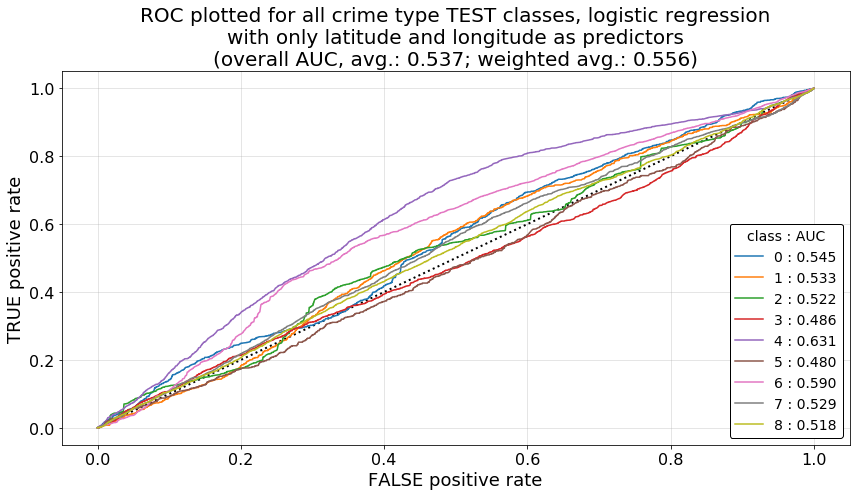

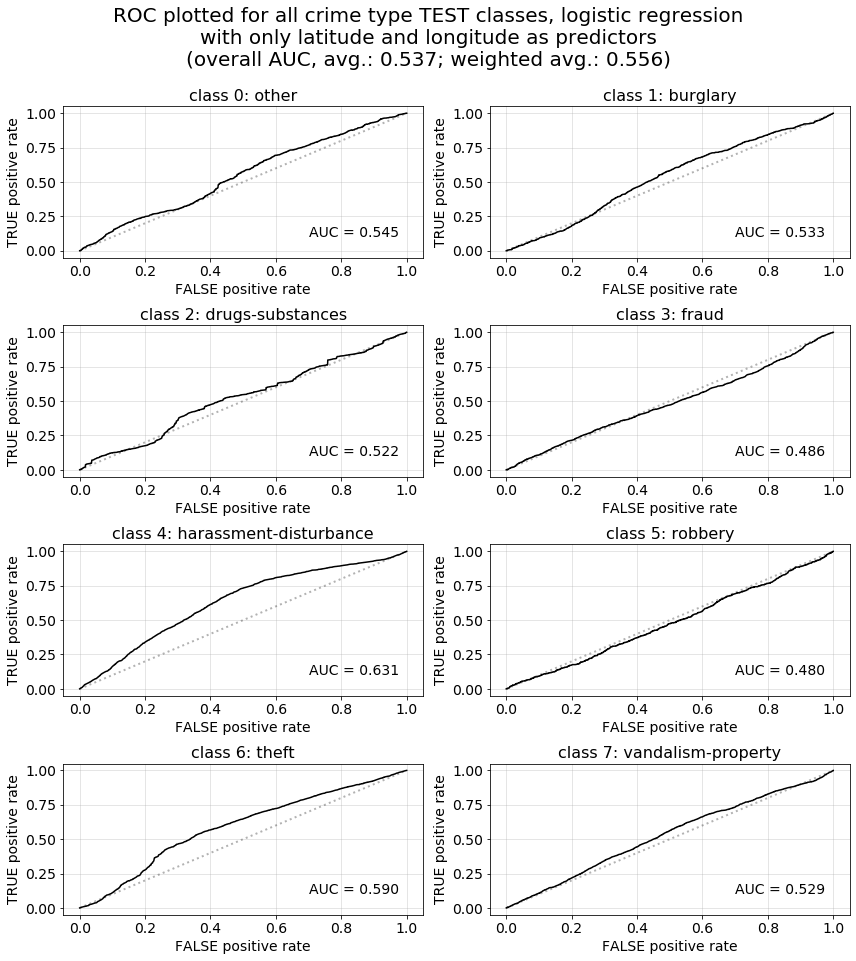

In [24]:
auc_inputs = [mnlogloc_dict[key]['test'] for key in ['auc', 'auc_weighted', 'roc_auc_dict']]

title = 'ROC plotted for all crime type TEST classes, logistic regression\n'\
        'with only latitude and longitude as predictors'
savepath = os.path.join(FIGURES_ROOT, 'roc-lat-lon-only.png')

plot_roc_all_classes(*auc_inputs, title, savepath)

savepath = os.path.join(FIGURES_ROOT, 'roc-by-class-lat-lon-only.png')

plot_roc_all_classes_individual(*auc_inputs, title, savepath)

In [27]:
%%time

cols = ['lat', 'lon']

solver = 'lbfgs'
C = 100000
max_iter = 1000

# fit a model again as multinomial for comparison of results
multi_class='multinomial'
class_weight='balanced'

mnloglocbal_dict = generate_model_dict(
    LogisticRegression,
    X_train[cols],
    X_test[cols],
    y_train,
    y_test,
    class_dict,
    C=C,
    solver=solver,
    max_iter=max_iter,
    multi_class=multi_class,
    class_weight=class_weight,
    random_state=20
)

print_model_results(mnloglocbal_dict,accuracy='both', auc='both',
                        pred_counts='both', conf_matrix='both',
                        class_metrics='both')


The fitted model:

LogisticRegression(C=100000, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=20, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)


This model resulted in the following accuracy:

Training	0.1295
Test		0.1332


The model AUC is:

		weighted	unweighted
Training	0.5487		0.5382
Test		0.5529		0.5395


The number of classes predicted by class are:

TRAINING
       count  proportion
class                   
0      53841    0.419479
1       6662    0.051904
2       1595    0.012427
3       2222    0.017312
4      52740    0.410901
5       3164    0.024651
6       3877    0.030206
7       1837    0.014312
8       2414    0.018808

TEST
       count  proportion
class                   
0      13476    0.419970
1       1624    0.050611
2        423    0.013182
3       

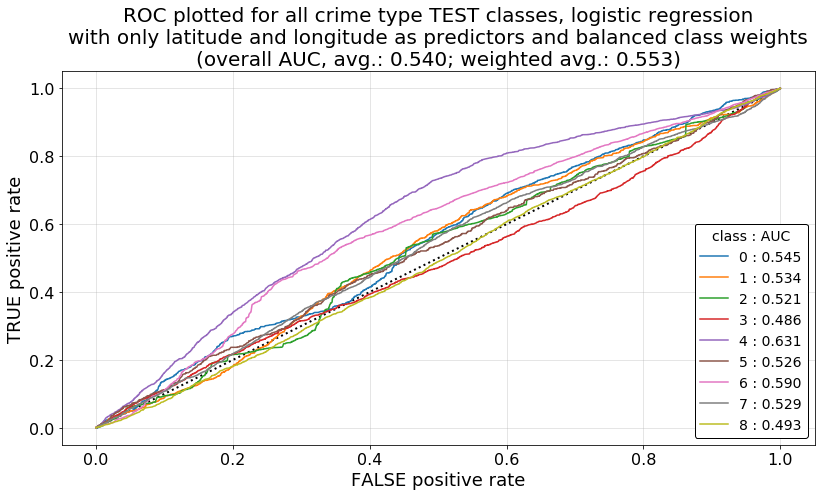

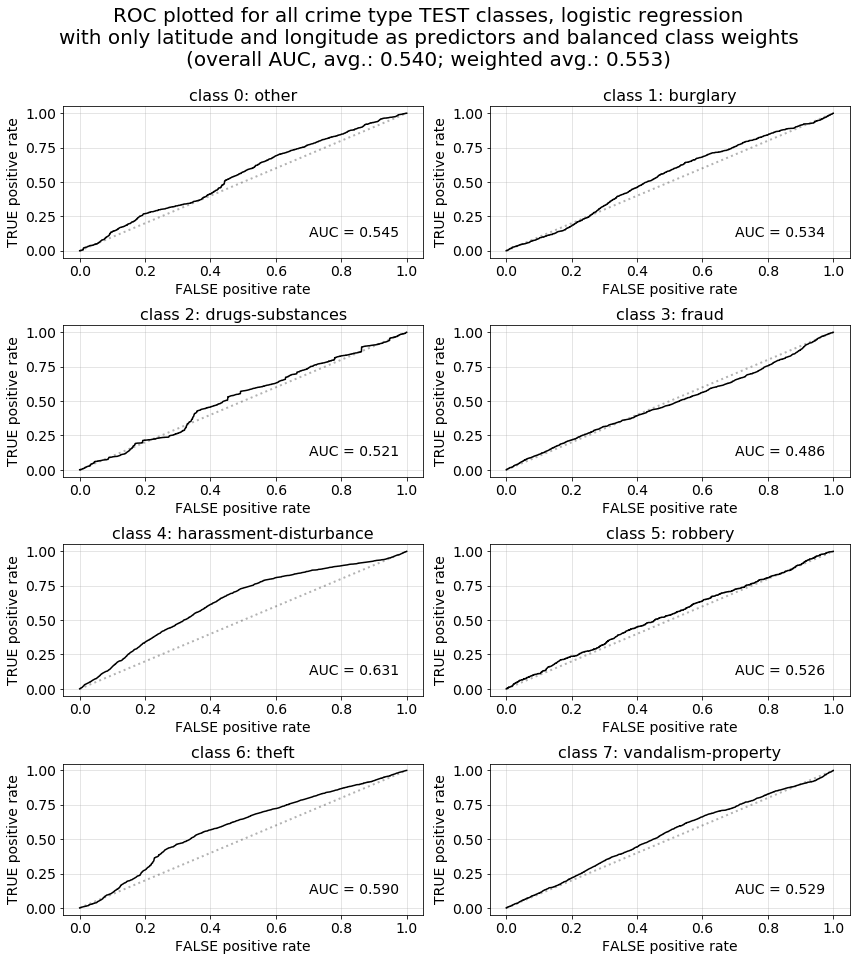

In [28]:
auc_inputs = [mnloglocbal_dict[key]['test'] for key in ['auc', 'auc_weighted', 'roc_auc_dict']]

title = 'ROC plotted for all crime type TEST classes, logistic regression\n'\
        'with only latitude and longitude as predictors and balanced class weights'
savepath = os.path.join(FIGURES_ROOT, 'roc-lat-lon-only-bal.png')

plot_roc_all_classes(*auc_inputs, title, savepath)

savepath = os.path.join(FIGURES_ROOT, 'roc-by-class-lat-lon-only-bal.png')

plot_roc_all_classes_individual(*auc_inputs, title, savepath)

In [15]:
%%time

solver = 'lbfgs'
C = 100000
max_iter = 1000

# fit a model again as multinomial for comparison of results
multi_class='multinomial'

MNLogLocs = LogisticRegression(
    C=C,
    solver=solver,
    max_iter=max_iter,
    multi_class=multi_class,
    random_state=20
).fit(X_train[['lat', 'lon']], y_train)

mnloglocs_score_train = MNLogLocs.score(X_train[['lat', 'lon']], y_train)
mnloglocs_score_test = MNLogLocs.score(X_test[['lat', 'lon']], y_test)
mnloglocs_pred_train = MNLogLocs.predict(X_train[['lat', 'lon']])
mnloglocs_pred_test = MNLogLocs.predict(X_test[['lat', 'lon']])

print(MNLogLocs)
print()
print(
    'The resulting training and test accuracy scores are:\n\n'\
    'Training\t{0:.4f}\nTEST\t\t{1:.4f}\n'.format(
        mnloglocs_score_train,
        mnloglocs_score_test
    )
)

LogisticRegression(C=100000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=20, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

The resulting training and test accuracy scores are:

Training	0.2706
TEST		0.2733

CPU times: user 15 s, sys: 13.2 s, total: 28.2 s
Wall time: 3.93 s


In [152]:
list(mnlogloc_dict.keys())

['model',
 'predictions',
 'probabilities',
 'pred_counts',
 'conf_matrix',
 'class_metrics',
 'accuracy',
 'auc',
 'auc_weighted',
 'roc_auc_dict']

In [21]:
pred_counts_train, pred_counts_test = summarize_predictions(mnloglocs_pred_train, mnloglocs_pred_test)
print('\n')
mnloglocs_cmat_train = make_conf_matrix(mnloglocs_pred_train, y_train)
mnloglocs_cmat_test = make_conf_matrix(mnloglocs_pred_test, y_test)
print(
    'The training and test confusion matrices for the model are:\n\n'\
    'TRAINING\n\n{}\n\n\nTEST\n\n{}\n'.format(
        mnloglocs_cmat_train,
        mnloglocs_cmat_test
    )
)

The number of classes predicted by class for both the training and test sets are:

TRAINING
Class	Proportion	Predictions
4	0.1203		15,446
6	0.8797		112,906

TEST
Class	Proportion	Predictions
4	0.1228		3,939
6	0.8772		28,149


The training and test confusion matrices for the model are:

TRAINING

Actual        0     1      2     3      4     5      6      7      8   Total
Predicted                                                                   
0             0     0      0     0      0     0      0      0      0       0
1             0     0      0     0      0     0      0      0      0       0
2             0     0      0     0      0     0      0      0      0       0
3             0     0      0     0      0     0      0      0      0       0
4           476   755   1420  1491   3477   370   3300   1827   2330   15446
5             0     0      0     0      0     0      0      0      0       0
6          5845  4909  11662  8096  17290  3053  31255  11883  18913  112906
7         

In [17]:
%%time

solver = 'lbfgs'
C = 100000
max_iter = 1000
class_weight = 'balanced'

# fit a model again as multinomial for comparison of results
multi_class='ovr'

MNLogLocsBal = LogisticRegression(
    C=C,
    solver=solver,
    max_iter=max_iter,
    multi_class=multi_class,
    random_state=20,
    class_weight = class_weight
).fit(X_train[['lat', 'lon']], y_train)

mnloglocsbal_score_train = MNLogLocsBal.score(X_train[['lat', 'lon']], y_train)
mnloglocsbal_score_test = MNLogLocsBal.score(X_test[['lat', 'lon']], y_test)
mnloglocsbal_pred_train = MNLogLocsBal.predict(X_train[['lat', 'lon']])
mnloglocsbal_pred_test = MNLogLocsBal.predict(X_test[['lat', 'lon']])
mnloglocsbal_predprob_train = MNLogLocsBal.predict_proba(X_train[['lat', 'lon']])
mnloglocsbal_predprob_test = MNLogLocsBal.predict_proba(X_test[['lat', 'lon']])

print(MNLogLocsBal)
print()
print(
    'The resulting training and test accuracy scores are:\n\n'\
    'Training\t{0:.4f}\nTEST\t\t{1:.4f}\n'.format(
        mnloglocsbal_score_train,
        mnloglocsbal_score_test
    )
)

LogisticRegression(C=100000, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=20, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

The resulting training and test accuracy scores are:

Training	0.2584
TEST		0.2609

CPU times: user 11.2 s, sys: 9.85 s, total: 21.1 s
Wall time: 2.76 s


In [18]:
summarize_predictions(mnloglocsbal_pred_train, mnloglocsbal_pred_test)
print('\n')
mnloglocsbal_cmat_train = make_conf_matrix(mnloglocsbal_pred_train, y_train)
mnloglocsbal_cmat_test = make_conf_matrix(mnloglocsbal_pred_test, y_test)
print(
    'The training and test confusion matrices for the model are:\n\n'\
    'TRAINING\n\n{}\n\n\nTEST\n\n{}\n'.format(
        mnloglocsbal_cmat_train,
        mnloglocsbal_cmat_test
    )
)

The number of classes predicted by class for both the training and test sets are:

TRAINING
Class	Proportion	Predictions
0	0.0659		8,453
1	0.0452		5,797
4	0.4279		54,925
6	0.4611		59,177

TEST
Class	Proportion	Predictions
0	0.0672		2,157
1	0.0443		1,420
4	0.4318		13,854
6	0.4568		14,657


The training and test confusion matrices for the model are:

TRAINING

Actual        0     1      2     3      4     5      6      7      8   Total
Predicted                                                                   
0           506   344   1561   542    910   191   2155    997   1247    8453
1           182   266    523   401   1170   112   1552    589   1002    5797
2             0     0      0     0      0     0      0      0      0       0
3             0     0      0     0      0     0      0      0      0       0
4          1946  2497   5194  3928  12563  1516  11014   6606   9661   54925
5             0     0      0     0      0     0      0      0      0       0
6          3687  2557  

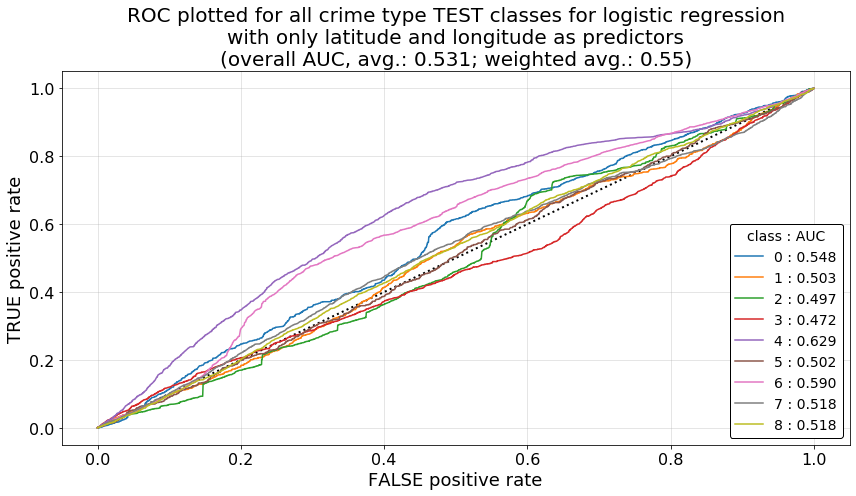

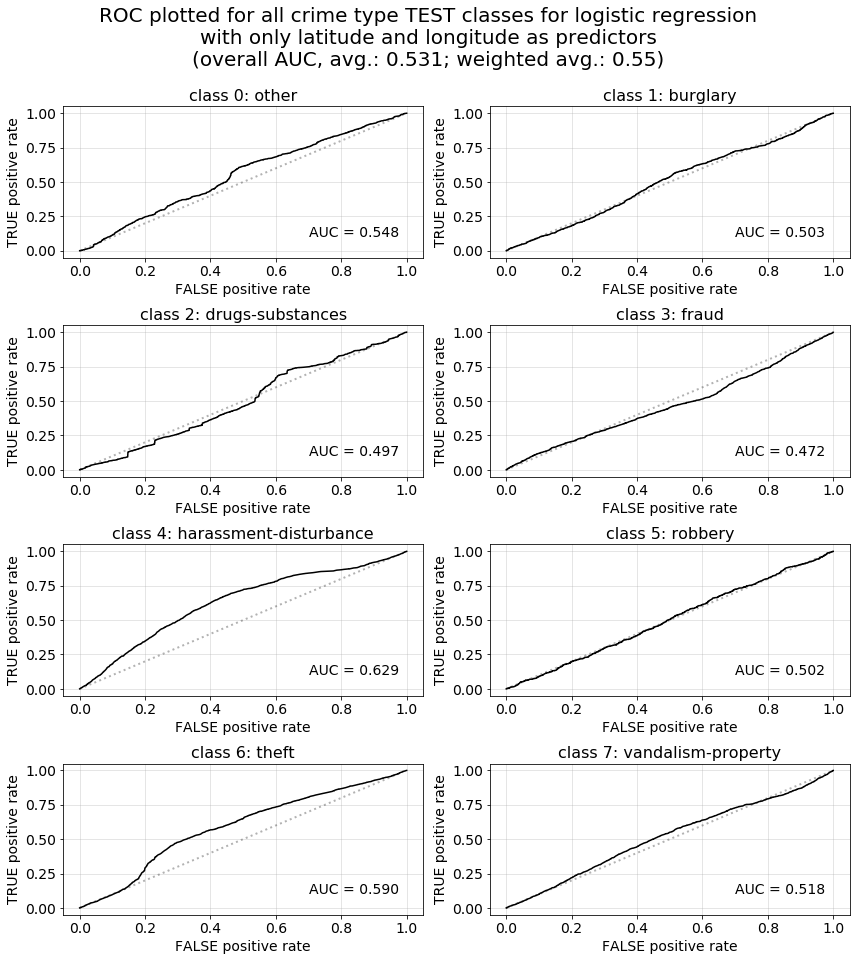

In [19]:
predicted_probabilities = mnloglocsbal_predprob_test
class_dict = crime_type_dict

mnloglocsbal_auc, mnloglocsbal_auc_weighted, mnloglocsbal_roc_curve_dict = generate_roc_auc(
    y_test, predicted_probabilities, class_dict
)

overall_auc = mnloglocsbal_auc
overall_auc_weighted = mnloglocsbal_auc_weighted
roc_curve_dict = mnloglocsbal_roc_curve_dict

title = 'ROC plotted for all crime type TEST classes for logistic regression\n'\
        'with only latitude and longitude as predictors'
savepath = None

plot_roc_all_classes(overall_auc, overall_auc_weighted, roc_curve_dict, title, savepath)

title = 'ROC plotted for all crime type TEST classes for logistic regression\n'\
        'with only latitude and longitude as predictors'
savepath = None

plot_roc_all_classes_individual(overall_auc, overall_auc_weighted, roc_curve_dict, title, savepath)

## MODEL 2: Fit a multi-class multiple Logistic regression model first to the SCALED data and inspect results

In [188]:
%%time

# redo baseline predictors
cols = [
    'lat',
    'lon',
    'commercial-mix-ratio',
    'industrial-mix-ratio',
    'owner-occupied-ratio',
    'residential-median-value',
    'residential-gini-coef',
    'commercial-mix-ratio-3yr-cagr',
    'industrial-mix-ratio-3yr-cagr',
    'owner-occupied-ratio-3yr-cagr',
    'residential-gini-coef-3yr-cagr',
    'residential-median-value-3yr-cagr'
]

solver = 'lbfgs'
C = 100000
max_iter = 1000

# fit a model again as multinomial for comparison of results
multi_class='multinomial'

MNLogBase = LogisticRegression(
    C=C,
    solver=solver,
    max_iter=max_iter,
    multi_class=multi_class,
    random_state=20
).fit(X_train[cols], y_train)

mnlogbase_score_train = MNLogBase.score(X_train[cols], y_train)
mnlogbase_score_test = MNLogBase.score(X_test[cols], y_test)
mnlogbase_pred_train = MNLogBase.predict(X_train[cols])
mnlogbase_pred_test = MNLogBase.predict(X_test[cols])

print(MNLogBase)
print()
print(
    'The resulting training and test accuracy scores are:\n\n'\
    'Training\t{0:.4f}\nTEST\t\t{1:.4f}\n'.format(
        mnlogbase_score_train,
        mnlogbase_score_test
    )
)

LogisticRegression(C=100000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=20, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

The resulting training and test accuracy scores are:

Training	0.2692
TEST		0.2692

CPU times: user 4.88 s, sys: 39.9 ms, total: 4.92 s
Wall time: 1.63 s


In [189]:
summarize_predictions(mnlogbase_pred_train, mnlogbase_pred_test)
print('\n')
mnlogbase_cmat_train = make_conf_matrix(mnlogbase_pred_train, y_train)
mnlogbase_cmat_test = make_conf_matrix(mnlogbase_pred_test, y_test)
print(
    'The training and test confusion matrices for the model are:\n\n'\
    'TRAINING\n\n{}\n\n\nTEST\n\n{}\n'.format(
        mnlogbase_cmat_train,
        mnlogbase_cmat_test
    )
)

The number of classes predicted by class for both the training and test sets are:

TRAINING
Class	Proportion	Predictions
6	1.0000		128,352

TEST
Class	Proportion	Predictions
6	1.0000		32,088


The training and test confusion matrices for the model are:

TRAINING

Actual        0     1      2     3      4     5      6      7      8   Total
Predicted                                                                   
0             0     0      0     0      0     0      0      0      0       0
1             0     0      0     0      0     0      0      0      0       0
2             0     0      0     0      0     0      0      0      0       0
3             0     0      0     0      0     0      0      0      0       0
4             0     0      0     0      0     0      0      0      0       0
5             0     0      0     0      0     0      0      0      0       0
6          6321  5664  13082  9587  20767  3423  34555  13710  21243  128352
7             0     0      0     0      0  

In [192]:
solver = 'lbfgs'
C = 100000
max_iter = 1000

# fit a model again as multinomial for comparison of results
multi_class='multinomial'

MNLogBaseScaled = LogisticRegression(
    C=C,
    solver=solver,
    max_iter=max_iter,
    multi_class=multi_class,
    random_state=20
).fit(X_train_scaled[cols], y_train)

mnlogbasescaled_score_train = MNLogBaseScaled.score(X_train_scaled[cols], y_train)
mnlogbasescaled_score_test = MNLogBaseScaled.score(X_test_scaled[cols], y_test)
mnlogbasescaled_pred_train = MNLogBaseScaled.predict(X_train_scaled[cols])
mnlogbasescaled_pred_test = MNLogBaseScaled.predict(X_test_scaled[cols])

print(MNLogBaseScaled)
print()
print(
    'The resulting training and test accuracy scores are:\n\n'\
    'Training\t{0:.4f}\nTEST\t\t{1:.4f}\n'.format(
        mnlogbasescaled_score_train,
        mnlogbasescaled_score_test
    )
)

LogisticRegression(C=100000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=20, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

The resulting training and test accuracy scores are:

Training	0.2901
TEST		0.2924



In [193]:
summarize_predictions(mnlogbasescaled_pred_train, mnlogbasescaled_pred_test)
print('\n')
mnlogbasescaled_cmat_train = make_conf_matrix(mnlogbasescaled_pred_train, y_train)
mnlogbasescaled_cmat_test = make_conf_matrix(mnlogbasescaled_pred_test, y_test)
print(
    'The training and test confusion matrices for the model are:\n\n'\
    'TRAINING\n\n{}\n\n\nTEST\n\n{}\n'.format(
        mnlogbasescaled_cmat_train,
        mnlogbasescaled_cmat_test
    )
)

The number of classes predicted by class for both the training and test sets are:

TRAINING
Class	Proportion	Predictions
2	0.0142		1,823
3	0.0002		31
4	0.3011		38,646
6	0.6669		85,594
8	0.0176		2,258

TEST
Class	Proportion	Predictions
2	0.0141		451
3	0.0002		8
4	0.3048		9,782
6	0.6638		21,299
8	0.0171		548


The training and test confusion matrices for the model are:

TRAINING

Actual        0     1      2     3      4     5      6      7      8   Total
Predicted                                                                   
0             0     0      0     0      0     0      0      0      0       0
1             0     0      0     0      0     0      0      0      0       0
2            53    90    502   130    148    58    463    168    211    1823
3             0     3      2     9      3     1     11      1      1      31
4          1367  1694   3281  2616   9656  1130   7074   4751   7077   38646
5             0     0      0     0      0     0      0      0      0       0
6  

In [194]:
solver = 'lbfgs'
C = 100000
max_iter = 1000

# fit a model again as multinomial for comparison of results
multi_class='multinomial'
class_weight='balanced'

MNLogBaseScaledBal = LogisticRegression(
    C=C,
    solver=solver,
    max_iter=max_iter,
    multi_class=multi_class,
    random_state=20,
    class_weight=class_weight
).fit(X_train_scaled[cols], y_train)

mnlogbasescaledbal_score_train = MNLogBaseScaledBal.score(X_train_scaled[cols], y_train)
mnlogbasescaledbal_score_test = MNLogBaseScaledBal.score(X_test_scaled[cols], y_test)
mnlogbasescaledbal_pred_train = MNLogBaseScaledBal.predict(X_train_scaled[cols])
mnlogbasescaledbal_pred_test = MNLogBaseScaledBal.predict(X_test_scaled[cols])

print(MNLogBaseScaledBal)
print()
print(
    'The resulting training and test accuracy scores are:\n\n'\
    'Training\t{0:.4f}\nTEST\t\t{1:.4f}\n'.format(
        mnlogbasescaledbal_score_train,
        mnlogbasescaledbal_score_test
    )
)

LogisticRegression(C=100000, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=20, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

The resulting training and test accuracy scores are:

Training	0.2107
TEST		0.2136



In [195]:
summarize_predictions(mnlogbasescaledbal_pred_train, mnlogbasescaledbal_pred_test)
print('\n')
mnlogbasescaledbal_cmat_train = make_conf_matrix(mnlogbasescaledbal_pred_train, y_train)
mnlogbasescaledbal_cmat_test = make_conf_matrix(mnlogbasescaledbal_pred_test, y_test)
print(
    'The training and test confusion matrices for the model are:\n\n'\
    'TRAINING\n\n{}\n\n\nTEST\n\n{}\n'.format(
        mnlogbasescaledbal_cmat_train,
        mnlogbasescaledbal_cmat_test
    )
)

The number of classes predicted by class for both the training and test sets are:

TRAINING
Class	Proportion	Predictions
0	0.1238		15,890
1	0.1254		16,091
2	0.1264		16,227
3	0.0479		6,143
4	0.3443		44,198
5	0.0363		4,661
6	0.1608		20,645
7	0.0275		3,536
8	0.0075		961

TEST
Class	Proportion	Predictions
0	0.1210		3,882
1	0.1261		4,047
2	0.1259		4,040
3	0.0475		1,524
4	0.3470		11,135
5	0.0358		1,148
6	0.1612		5,174
7	0.0281		903
8	0.0073		235


The training and test confusion matrices for the model are:

TRAINING

Actual        0     1      2     3      4     5      6      7      8   Total
Predicted                                                                   
0          1470   614   1521  1236   1848   438   4547   1543   2673   15890
1           716  1149   1628  1331   2325   384   4417   1817   2324   16091
2           675   669   2975  1041   2020   417   4225   1568   2637   16227
3           211   271    700   632    985   110   1640    674    920    6143
4          1618  1881

## MODEL 3: Fit a multi-class multiple Logistic regression model using ALL predictors

In [142]:
%%time

# redo baseline predictors
cols = list(X_train.columns)

solver = 'lbfgs'
C = 100000
max_iter = 1000

# fit a model again as multinomial for comparison of results
multi_class='multinomial'

MNLogAll = LogisticRegression(
    C=C,
    solver=solver,
    max_iter=max_iter,
    multi_class=multi_class,
    random_state=20
).fit(X_train[cols], y_train)

mnlogall_score_train = MNLogAll.score(X_train[cols], y_train)
mnlogall_score_test = MNLogAll.score(X_test[cols], y_test)
mnlogall_pred_train = MNLogAll.predict(X_train[cols])
mnlogall_pred_test = MNLogAll.predict(X_test[cols])

print(MNLogAll)
print()
print(
    'The resulting training and test accuracy scores are:\n\n'\
    'Training\t{0:.4f}\nTEST\t\t{1:.4f}\n'.format(
        mnlogall_score_train,
        mnlogall_score_test
    )
)

LogisticRegression(C=100000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=20, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

The resulting training and test accuracy scores are:

Training	0.2692
TEST		0.2692

CPU times: user 18.5 s, sys: 232 ms, total: 18.7 s
Wall time: 5.09 s


In [143]:
summarize_predictions(mnlogall_pred_train, mnlogall_pred_test)

The number of classes predicted by class for both the training and test sets are:

TRAINING
Class	Proportion	Predictions
6	1.0000		128,352

TEST
Class	Proportion	Predictions
6	1.0000		32,088


In [144]:
%%time

# redo baseline predictors
cols = list(X_train.columns)

solver = 'lbfgs'
C = 100000
max_iter = 1000

# fit a model again as multinomial for comparison of results
multi_class='ovr'

OVRLogAll = LogisticRegression(
    C=C,
    solver=solver,
    max_iter=max_iter,
    multi_class=multi_class,
    random_state=20
).fit(X_train[cols], y_train)

ovrlogall_score_train = OVRLogAll.score(X_train[cols], y_train)
ovrlogall_score_test = OVRLogAll.score(X_test[cols], y_test)
ovrlogall_pred_train = OVRLogAll.predict(X_train[cols])
ovrlogall_pred_test = OVRLogAll.predict(X_test[cols])

print(OVRLogAll)
print()
print(
    'The resulting training and test accuracy scores are:\n\n'\
    'Training\t{0:.4f}\nTEST\t\t{1:.4f}\n'.format(
        ovrlogall_score_train,
        ovrlogall_score_test
    )
)

LogisticRegression(C=100000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=20, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

The resulting training and test accuracy scores are:

Training	0.2595
TEST		0.2599

CPU times: user 15.1 s, sys: 152 ms, total: 15.3 s
Wall time: 3.84 s


In [145]:
summarize_predictions(ovrlogall_pred_train, ovrlogall_pred_test)

The number of classes predicted by class for both the training and test sets are:

TRAINING
Class	Proportion	Predictions
4	0.0061		788
6	0.6801		87,294
8	0.3137		40,270

TEST
Class	Proportion	Predictions
4	0.0062		198
6	0.6841		21,952
8	0.3097		9,938


## MODEL 3: Fit a multi-class multiple Logistic regression model with LASSO (L1) regularization to the SCALED data and inspect results

In [147]:
%%time

# redo baseline predictors
cols = list(X_train.columns)

solver = 'lbfgs'
C = 100000
max_iter = 1000
class_weight = 'balanced'

# fit a model again as multinomial for comparison of results
multi_class='multinomial'

MNLogAllBal = LogisticRegression(
    C=C,
    solver=solver,
    max_iter=max_iter,
    multi_class=multi_class,
    random_state=20,
    class_weight=class_weight
).fit(X_train[cols], y_train)

mnlogallbal_score_train = MNLogAllBal.score(X_train[cols], y_train)
mnlogallbal_score_test = MNLogAllBal.score(X_test[cols], y_test)
mnlogallbal_pred_train = MNLogAllBal.predict(X_train[cols])
mnlogallbal_pred_test = MNLogAllBal.predict(X_test[cols])

print(MNLogAllBal)
print()
print(
    'The resulting training and test accuracy scores are:\n\n'\
    'Training\t{0:.4f}\nTEST\t\t{1:.4f}\n'.format(
        mnlogallbal_score_train,
        mnlogallbal_score_test
    )
)

LogisticRegression(C=100000, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=20, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

The resulting training and test accuracy scores are:

Training	0.2009
TEST		0.2026

CPU times: user 5.43 s, sys: 72.1 ms, total: 5.5 s
Wall time: 1.66 s


In [149]:
summarize_predictions(mnlogallbal_pred_train, mnlogallbal_pred_test)

The number of classes predicted by class for both the training and test sets are:

TRAINING
Class	Proportion	Predictions
0	0.0696		8,929
1	0.1305		16,755
3	0.0991		12,726
6	0.6279		80,591
7	0.0729		9,351

TEST
Class	Proportion	Predictions
0	0.0684		2,196
1	0.1309		4,199
3	0.0986		3,164
6	0.6278		20,144
7	0.0743		2,385


In [151]:
%%time

# redo baseline predictors
cols = list(X_train.columns)

solver = 'lbfgs'
C = 100000
max_iter = 1000
class_weight = 'balanced'

# fit a model again as multinomial for comparison of results
multi_class='ovr'

OVRLogAllBal = LogisticRegression(
    C=C,
    solver=solver,
    max_iter=max_iter,
    multi_class=multi_class,
    random_state=20,
    class_weight=class_weight
).fit(X_train[cols], y_train)

ovrlogallbal_score_train = OVRLogAllBal.score(X_train[cols], y_train)
ovrlogallbal_score_test = OVRLogAllBal.score(X_test[cols], y_test)
ovrlogallbal_pred_train = OVRLogAllBal.predict(X_train[cols])
ovrlogallbal_pred_test = OVRLogAllBal.predict(X_test[cols])

print(OVRLogAllBal)
print()
print(
    'The resulting training and test accuracy scores are:\n\n'\
    'Training\t{0:.4f}\nTEST\t\t{1:.4f}\n'.format(
        ovrlogallbal_score_train,
        ovrlogallbal_score_test
    )
)

LogisticRegression(C=100000, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=20, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

The resulting training and test accuracy scores are:

Training	0.2155
TEST		0.2140

CPU times: user 11.4 s, sys: 152 ms, total: 11.6 s
Wall time: 2.93 s


In [152]:
summarize_predictions(ovrlogallbal_pred_train, ovrlogallbal_pred_test)

The number of classes predicted by class for both the training and test sets are:

TRAINING
Class	Proportion	Predictions
0	0.0540		6,936
1	0.0065		835
2	0.1210		15,537
3	0.0018		231
4	0.3870		49,672
5	0.0953		12,230
6	0.2830		36,327
7	0.0513		6,584

TEST
Class	Proportion	Predictions
0	0.0547		1,755
1	0.0065		210
2	0.1229		3,944
3	0.0017		54
4	0.3834		12,304
5	0.0936		3,004
6	0.2834		9,095
7	0.0537		1,722


In [24]:
%%time

solver = 'saga'
C = 1
max_iter = 10000
penalty = 'l1'

# fit OVR model without L1 regularization
multi_class='ovr'

LassoScaledOVRLogModel = LogisticRegression(
    C=C,
    solver=solver,
    max_iter=max_iter,
    multi_class=multi_class,
    random_state=20,
    penalty=penalty
).fit(X_train_scaled, y_train)

print(LassoScaledOVRLogModel)
print()
print(
    'The resulting training and test accuracy scores for the Lasso regularized OVR model '\
    'using the scaled data are:\n\n'\
    'Training\t{0:.4f}\nTEST\t\t{1:.4f}\n'.format(
        LassoScaledOVRLogModel.score(X_train_scaled, y_train),
        LassoScaledOVRLogModel.score(X_test_scaled, y_test)
    )
)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='ovr', n_jobs=None, penalty='l1',
                   random_state=20, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

The resulting training and test accuracy scores for the Lasso regularized OVR model using the scaled data are:

Training	0.2732
TEST		0.2726

CPU times: user 31.6 s, sys: 23.9 ms, total: 31.6 s
Wall time: 31 s


In [25]:
%%time

solver = 'saga'
C = 1
max_iter = 10000
penalty = 'l1'

# fit OVR model without L1 regularization
multi_class='multinomial'

LassoScaledMNLogModel = LogisticRegression(
    C=C,
    solver=solver,
    max_iter=max_iter,
    multi_class=multi_class,
    random_state=20,
    penalty=penalty
).fit(X_train_scaled, y_train)

print(LassoScaledMNLogModel)
print()
print(
    'The resulting training and test accuracy scores for the Lasso regularized Multinomial model '\
    'using the scaled data are:\n\n'\
    'Training\t{0:.4f}\nTEST\t\t{1:.4f}\n'.format(
        LassoScaledMNLogModel.score(X_train_scaled, y_train),
        LassoScaledMNLogModel.score(X_test_scaled, y_test)
    )
)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='multinomial', n_jobs=None, penalty='l1',
                   random_state=20, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

The resulting training and test accuracy scores for the Lasso regularized Multinomial model using the scaled data are:

Training	0.2733
TEST		0.2730

CPU times: user 1min 14s, sys: 23.9 ms, total: 1min 14s
Wall time: 1min 13s


## Plot coefficients for Lasso Multinomial Logistic Regression

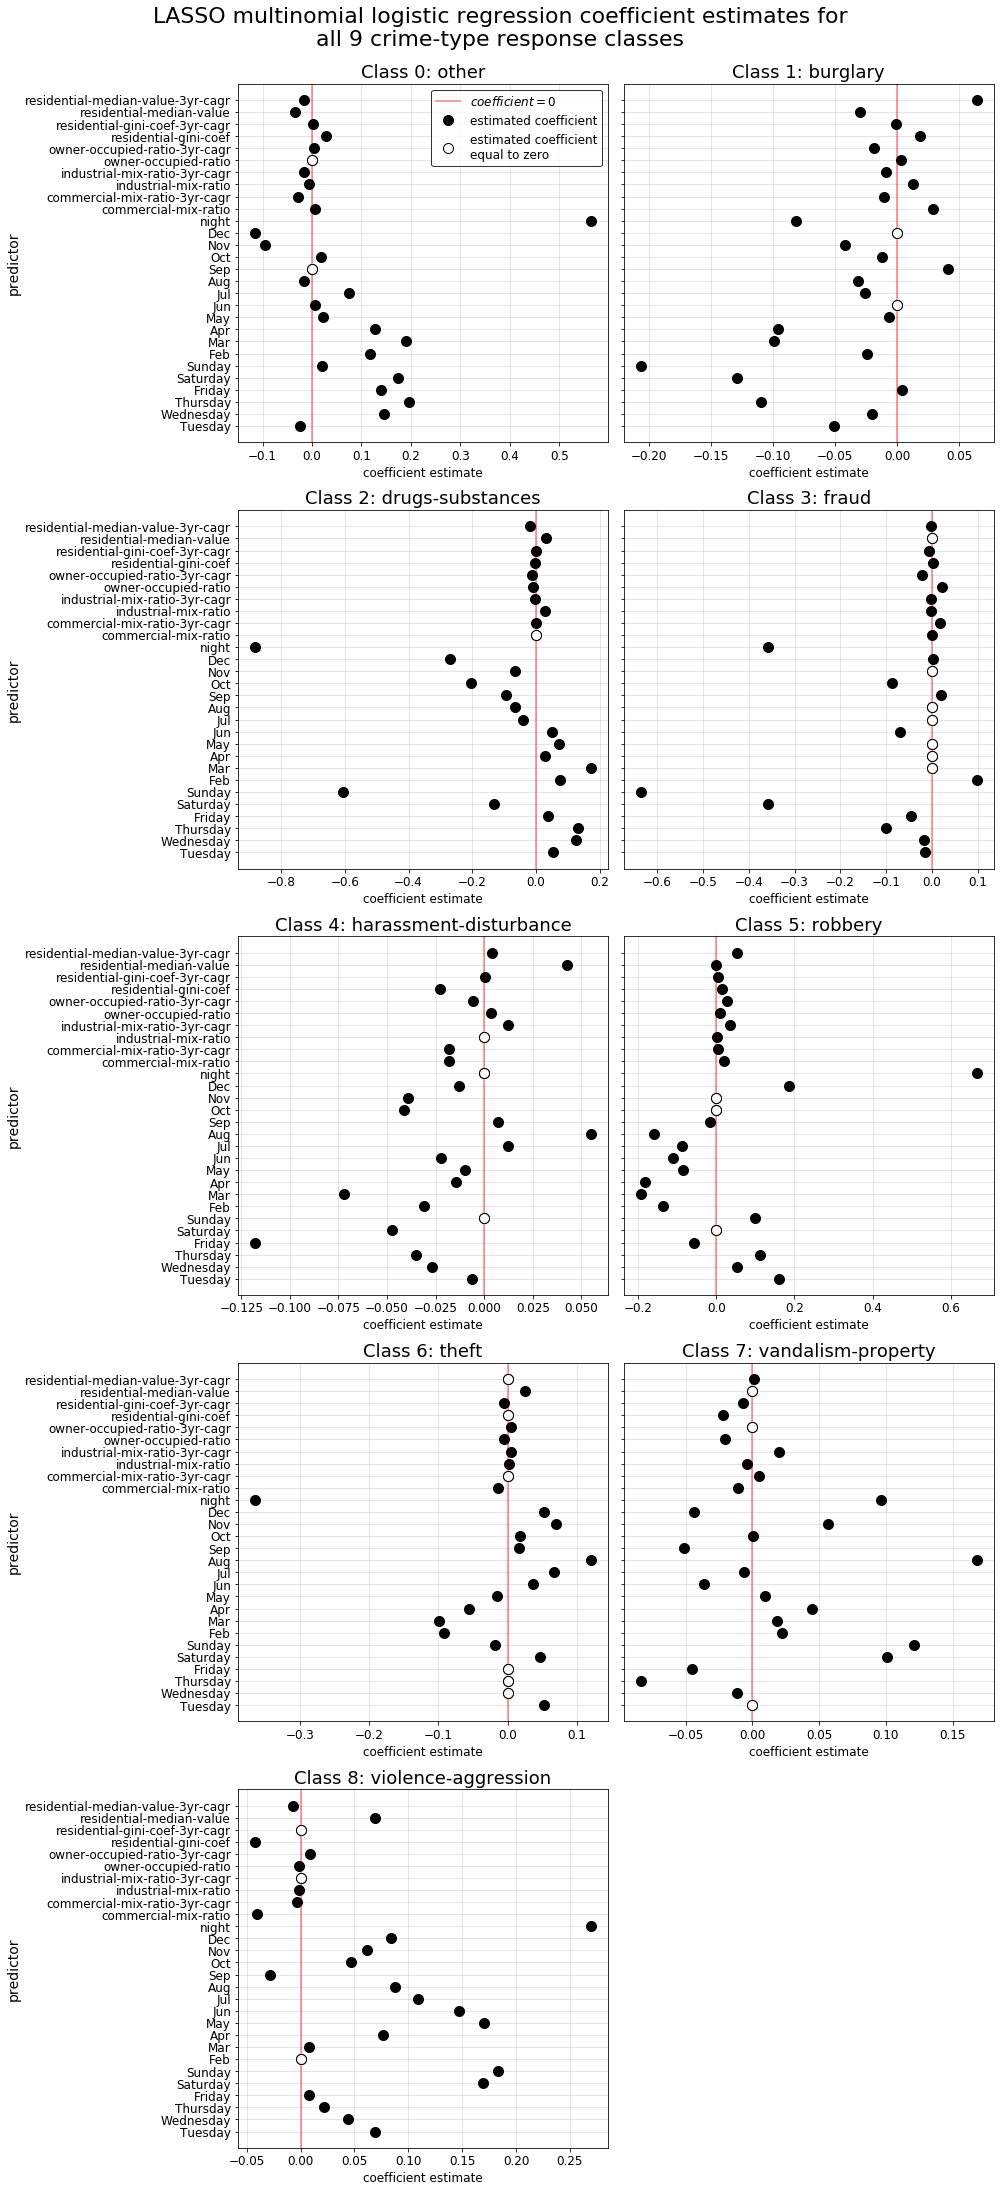

In [26]:
#plot comparison of model coefficients
savefig = True

# set values required for plotting
lasso_coefs = LassoScaledMNLogModel.coef_
predictor_labels = X_train_scaled.columns
crime_type_list = list(crime_type_dict.keys())

# make plot
fig, axes = plt.subplots(5, 2, sharey=True, figsize=(14,32))

plt.suptitle(
    'LASSO multinomial logistic regression coefficient estimates for\nall '\
    '{0} crime-type response classes'\
    ''.format(len(crime_type_list)),
    fontsize=22,
)

for i, ax in enumerate(axes.flat):
    if i < 9:
        ax.set_title('Class {0}: {1}'.format(i, crime_type_list[i]), fontsize=18)
    
        ax.axvline(0, c='r', alpha=0.5, label='$coefficient=0$')

        ax.plot(
            lasso_coefs[i],
            predictor_labels,
            lw = 0,
            marker='o',
            alpha=1,
            ms=10,
            color='k',
            label='estimated coefficient'
        )

        ax.plot(
            lasso_coefs[i][lasso_coefs[i]==0],
            predictor_labels[lasso_coefs[i]==0],
            lw = 0,
            marker='o',
            alpha=1,
            ms=10,
            color='white',
            markeredgecolor='k',
            label='estimated coefficient\nequal to zero'
        )

        ax.set_xlabel('coefficient estimate', fontsize=12)
        ax.grid(':', alpha=0.4)
        ax.tick_params('both', labelsize=12)

    if i % 2 == 0:
        ax.set_ylabel('predictor', fontsize=14)
    if i == 0:
        ax.legend(fontsize=12, markerscale=1, edgecolor='k')
        
    if i == 9:
        # hide all markings for final axis    
        for pos in ['right','top','bottom','left']:
            ax.spines[pos].set_visible(False)
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        ax.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)

plt.xticks(fontsize=12)
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
if savefig:
    plt.savefig(os.path.join(FIGURES_ROOT, 'base-model-lasso-coefficient-estimates.png'))
plt.show();